# Processing time series

This notebook runs through some sanity checks about the photon flux calculations, comparing them to Bijan's spreadsheet results. This is to ensure that we properly process the input cubes, and gives an idea of how everything is done. Here we take the fiducial example of 47 Uma c.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
plt.rc('text', usetex=True)

import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams['axes.labelsize'] = 18
import sys
import os

folder = '../../../../crispy'
if folder not in sys.path: sys.path.append(folder)


Populating the interactive namespace from numpy and matplotlib


## Calculate photon fluxes

### Calculate star rates

In [19]:
import glob

# load first filelist to get its shape
fileshape = (45,4,4)


import astropy.units as u
import astropy.constants as c
import astropy.analytic_functions as af

planet_radius = 1.27*c.R_jup
ref_star_T=9377*u.K
ref_star_Vmag=2.37
target_star_T=5887*u.K
target_star_Vmag=5.03

lamc=770.
BW=0.18
R=50
n_ref_star_imgs=30
Nlam = 45
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)*u.nm

tel_pupil_area=3.650265060424805*u.m**2

from crispy.tools.inputScene import convert_krist_cube,calc_contrast_Bijan
target_star_cube = convert_krist_cube(fileshape,lamlist,target_star_T,target_star_Vmag,tel_pupil_area)

print("%e" % np.sum(target_star_cube[:,0,0]/Nlam))

1.425832e+08


### this is the equivalent of convert_krist_cube but for the entire band

In [8]:
# We need to determine the coefficient of proportionality between a blackbody source and the
# actualy flux received (depends on size of the star, distance, etc)
# define Vband
lambda_cent = 550*u.nanometer

# this is the flux density per steradian (specific intensity) you would expect from Vband
flux_bb_F550 = af.blackbody_lambda(lambda_cent, target_star_T).to(u.Watt/u.m**2/u.um/u.sr)

# this is the actual flux density received in Vband
Vband_zero_pt = (3953*u.Jansky).to(u.Watt/u.m**2/u.Hertz)
Vband_zero_pt *= (c.c/lambda_cent**2)
flux_star_Vband = Vband_zero_pt*10**(-0.4*target_star_Vmag)

# the ratio is coefficient we seek; this will multiply a blackbody function to yield flux densities
# at all wavelengths
ratio_star = (flux_star_Vband/flux_bb_F550)

# this is the ratio which we want to multiply phot_Uma_Vband for the other bands
#print("Ratio of blackbodies is %f" % ratio_Uma)

# Now convert each slice to photons per second per square meter
dlam = lamlist[-1]-lamlist[0]
#         high = c.c/(lamlist[i]-dlam/2.)
#         low = c.c/(lamlist[i]+dlam/2.)
#         mid = 0.5*(low+high) # middle frequency
#         dnu = high-low
#         E_ph = (c.h*mid).to(u.J) # photon energy at middle frequency
#         BBlam = af.blackbody_nu(lamlist[i], star_T).to(u.Watt/u.m**2/u.Hertz/u.sr)
#         flux = (BBlam*ratio_star*dnu).to(u.W/u.m**2) # this is Watts per m2
#         photon_flux = flux/E_ph # This is in Photons per second per m2
#         newcube[i,:,:] += photon_flux.to(1./u.s/u.m**2)
E_ph = (c.h*c.c/lamlist[Nlam//2]).to(u.J) # photon energy at middle frequency
BBlam = af.blackbody_lambda(lamlist[Nlam//2], target_star_T).to(u.Watt/u.m**2/u.um/u.sr)
flux = (BBlam*ratio_star*dlam).to(u.W/u.m**2) # this is Watts per m2
photon_flux = flux/E_ph # This is in Photons per second per m2
print("Photon flux within band per m2: {:.4E}".format(photon_flux.to(1./u.s/u.m**2)))
print("Planet contrast: {:.4E}".format(calc_contrast_Bijan(lamlist,folder=None)[0]))
print("Planet flux within band per m2: {:.4E}".format(photon_flux.to(1/u.s/u.m**2)*calc_contrast_Bijan(lamlist,folder=None)[0]))

Photon flux within band per m2: 1.3975E+08 1 / (m2 s)
Planet contrast: 7.9584E-09
Planet flux: 1.1122E+00 1 / (m2 s)


### Electrons

In [17]:
t_pl = 0.0064 # total planet transmission
Atot = np.pi*(2.37*u.m/2.)**2
QE = 0.68
signalQE = 0.93*0.8*QE
single_bin_frac = 1./R/BW
print("Planet electron conversion rate: {:.4E}".format(single_bin_frac*t_pl*Atot*QE*photon_flux.to(1/u.s/u.m**2)*calc_contrast_Bijan(lamlist,folder=None)[0]))
print("Planet signal rate: {:.4E}".format(single_bin_frac*t_pl*Atot*signalQE*photon_flux.to(1/u.s/u.m**2)*calc_contrast_Bijan(lamlist,folder=None)[0]))

Planet electron conversion rate: 2.3726E-03 1 / s
Planet signal rate: 1.7652E-03 1 / s


### Compare directly to Bijan's fluxtable

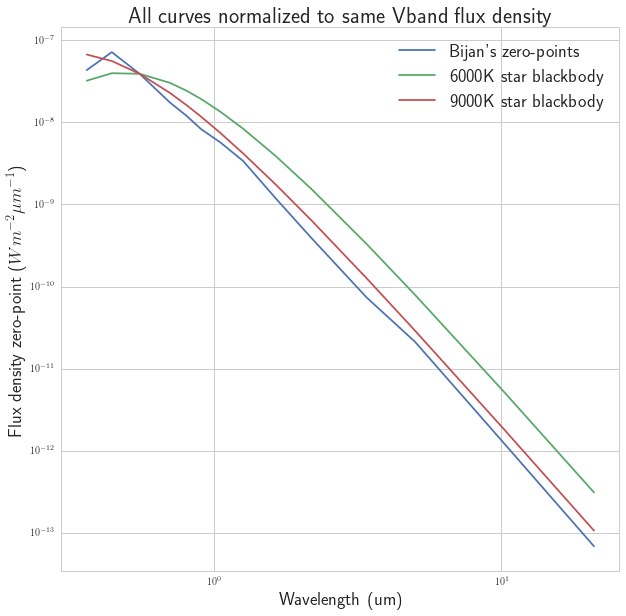

In [147]:
Bij_lams = [0.36,
0.44,
0.55,
0.70,
0.80,
0.90,
1.05,
1.26,
1.64,
2.18,
3.40,
5.00,
10.20,
21.00]
Bij_flux_densities = [4.35e-08,
7.20e-08,
3.92e-08,
1.76e-08,
1.21e-08,
8.30e-09,
5.72e-09,
3.40e-09,
1.18e-09,
3.90e-10,
7.30e-11,
2.12e-11,
1.23e-12,
6.80e-14]
plt.figure(figsize=(10,10))
plt.loglog(Bij_lams,Bij_flux_densities,label="Bijan's zero-points")
BB6 = af.blackbody_lambda(Bij_lams*u.um, 6000*u.K).to(u.Watt/u.m**2/u.um/u.sr)
BB9 = af.blackbody_lambda(Bij_lams*u.um, 9000*u.K).to(u.Watt/u.m**2/u.um/u.sr)

plt.loglog(Bij_lams,BB6/BB6[2]*Bij_flux_densities[2],label='6000K star blackbody')
plt.loglog(Bij_lams,BB9/BB9[2]*Bij_flux_densities[2],label='9000K star blackbody')
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux density zero-point ($Wm^{-2}\mu m^{-1}$)')
plt.title('All curves normalized to same Vband flux density',fontsize = 22)
plt.legend(fontsize=18)


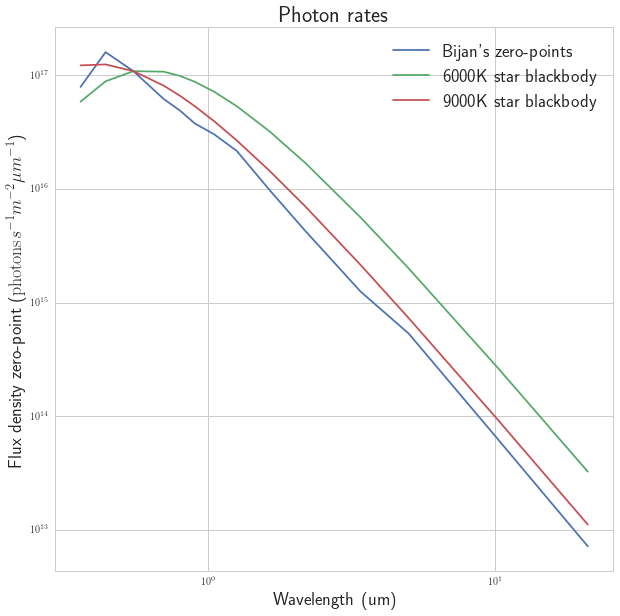

In [146]:
plt.figure(figsize=(10,10))
Bij_energies = c.c*c.h/Bij_lams
plt.loglog(Bij_lams,Bij_flux_densities/Bij_energies,label="Bijan's zero-points")
BB6 = af.blackbody_lambda(Bij_lams*u.um, 6000*u.K).to(u.Watt/u.m**2/u.um/u.sr)
BB9 = af.blackbody_lambda(Bij_lams*u.um, 9000*u.K).to(u.Watt/u.m**2/u.um/u.sr)

plt.loglog(Bij_lams,BB6/BB6[2]*Bij_flux_densities[2]/Bij_energies,label='6000K star blackbody')
plt.loglog(Bij_lams,BB9/BB9[2]*Bij_flux_densities[2]/Bij_energies,label='9000K star blackbody')
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux density zero-point ($\textrm{photons} s^{-1} m^{-2}\mu m^{-1}$)')
plt.title('Photon rates',fontsize = 22)
plt.legend(fontsize=18)


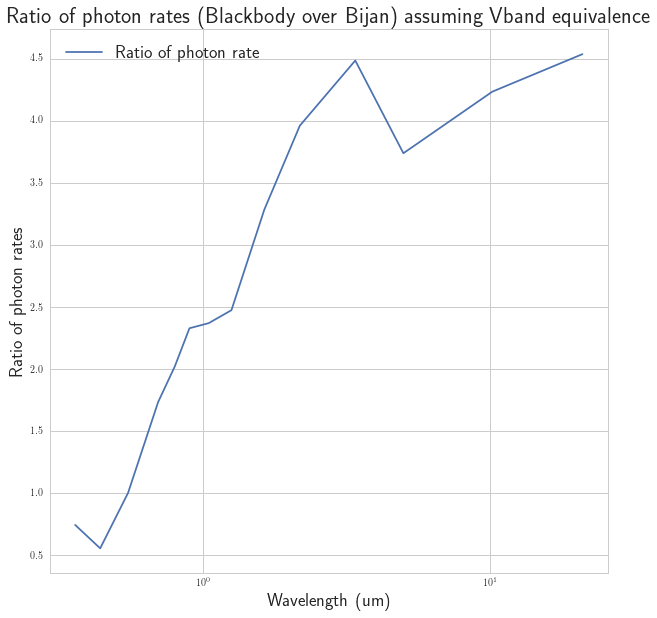

In [151]:
plt.figure(figsize=(10,10))
Bij_energies = c.c*c.h/Bij_lams
BB6 = af.blackbody_lambda(Bij_lams*u.um, 6000*u.K).to(u.Watt/u.m**2/u.um/u.sr)
plt.semilogx(Bij_lams,BB6/BB6[2]*Bij_flux_densities[2]/Bij_flux_densities,label="Ratio of photon rate")

plt.xlabel('Wavelength (um)')
plt.ylabel(r'Ratio of photon rates')
plt.title('Ratio of photon rates (Blackbody over Bijan) assuming Vband equivalence',fontsize = 22)
plt.legend(fontsize=18)


In [154]:
from scipy.interpolate import interp1d
ratios =interp1d(Bij_lams,BB6/BB6[2]*Bij_flux_densities[2]/Bij_flux_densities)
print("Ratio at 0.7 microns (Bijan's fluxes are underestimating the photon rate if value is positive):")
print(ratios(0.7))

Ratio at 0.7 microns (Bijan's fluxes are underestimating the photon rate if value is positive):
1.73229183163


# Photon rate calculations